# [通し課題]

8. DAY2、3で学んだことの取り組み • 交差検証、ホールドアウト法などで汎化性能を確認する  
 • 欠測値と異常値を確認し、適切に処理する  
 • DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する  
 • 交差検証によるパラメータチューニングを行う  
 • パラメータチューニング後のモデルによって、精度および結果の評価を行う  
 • その他、精度の向上ができるような処理に取り組み、精度を上げる  
 • できたところまでをNotebookでまとめ、宿題として提出する  
 • 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること  
 • 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます  
9. DAY4では、DAY3宿題の提出ファイルを元に、最終発表を実施いただ

# 0. DAY1~２での実施事項


In [1]:
#********************************************************************
# pandas,numpy,matplotlib,codecs,sklearnの各ライブラリをインポート
#********************************************************************

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns

#********************************************************************
#.該当課題のデータを読み込む
#********************************************************************
#201801のデータを読み込んでみる
with cd.open('ks-projects-201801.csv', 'r', 'utf-8', 'ignore') as f18:
    df_f18 = pd.read_csv(f18)
#df_f18 = pd.read_csv('ks-projects-201801.csv')

#********************************************************************
#.欠損値がある行は、とりあえずなくしてみる
#********************************************************************
#１個でも欠損値がある行はとりあえず削除してみる。
df_f18_dna = df_f18.dropna(how='any')

#********************************************************************
#.成功（'successful'）と失敗（'failed'）に絞って考える。
#********************************************************************
#成功だけを抽出したDFと失敗だけを抽出したDF
df_f18_success = df_f18_dna[df_f18_dna['state']=='successful']
df_f18_failed =  df_f18_dna[df_f18_dna['state']=='failed']
#両方を結合
df_f18_SorF = pd.concat([df_f18_success,df_f18_failed])

#********************************************************************
#.'state'をカテゴリ変数（文字列）から数値化してみる。
#********************************************************************
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#stateに出てくるカテゴリを覚えて
#stateを数値に変換
le = le.fit(df_f18_SorF['state'])
df_f18_SorF['state'] = le.transform(df_f18_SorF['state'])

#********************************************************************
#.'deadline' 'launched' の項目から期間'days'を日数で割り出す
#********************************************************************
# 'deadline' 'launched' の項目をdatetimeに変更
df_f18_SorF['deadline'] = pd.to_datetime(df_f18_SorF['deadline'], errors = 'coerce')
df_f18_SorF['launched'] = pd.to_datetime(df_f18_SorF['launched'], errors = 'coerce')
# 'deadline' 'launched' の間の日数を示す'period'を作成
df_f18_SorF['period'] = df_f18_SorF['deadline'] - df_f18_SorF['launched']

days = []

#'period'の日数を'days'に抽出
for i in df_f18_SorF.index:
    days.append(df_f18_SorF['period'][i].days)
#'days'列を追加
df_f18_SorF['days'] = days

#####################################
#異常値を除いたデータフレームを作る。
#####################################
#goalの異常値を除いたデータフレーム
df_train = df_f18_SorF[df_f18_SorF['goal']<99999999]

#####################################
#country,main_category,categoryをOne-Hotに変換する。
#####################################
df_train = pd.get_dummies(df_train, columns=['country', 'category', 'main_category'])


In [13]:

#********************************************************************
#.ロジスティック回帰で分類してみる。
#********************************************************************

#目的変数'state'を正解としてyに格納
y = df_train['state'].values
#説明変数'goal','backers','days','country_GB','country_HK','country_SG','country_US','main_category_rate','category_rate'を入力としてXに格納
X = df_train[['goal','days','country_GB','country_HK','country_SG','country_US','main_category_Art',\
                  'main_category_Comics','main_category_Dance','main_category_Design','main_category_Film & Video',\
                  'main_category_Games','main_category_Music','main_category_Theater',\
                 'category_Anthologies','category_Chiptune','category_Classical Music','category_Comic Books','category_Country & Folk',\
                  'category_Dance','category_Indie Rock','category_Jazz','category_Letterpress','category_Performances','category_Plays',\
                  'category_Residencies','category_Tabletop Games','category_Theater','category_Typography']].values

#ロジスティック回帰で学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

#********************************************************************
#.予測精度または識別精度を確認する
#　混同行列を作成し、Accuracy、Recall、Precisionを求める
#********************************************************************
# 学習した結果を使って説明変数を入力して予測
y_est = clf.predict(X)

#混同行列を作成
tn, fp, fn, tp = confusion_matrix(y, y_est).ravel()
print(fn, fp)
print(tn, tp)

#'Accuracy、Recall、Precisionを求めて表示
print('Accuracy  = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp)))
print('Recall    = {:.3f}%'.format(100 * (tp)/(fn+tp)))
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))

47591 29609
93594 36176
Accuracy  = 62.700%
Recall    = 43.186%
Precision = 54.991%


In [2]:
df_train.head()

,ID,name,currency,deadline,goal,launched,pledged,state,backers,usd pledged,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,1000014025,Monarch Espresso Bar,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224.0,52375.00,...,0,0,1,0,0,0,0,0,0,0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.0,1,16.0,1205.00,...,0,0,1,0,0,0,0,0,0,0
11,100005484,Lisa Lim New CD!,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.0,1,100.0,12700.00,...,0,0,0,0,0,1,0,0,0,0
14,1000057089,Tombstone: Old West tabletop game and miniatur...,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.0,1,761.0,57763.78,...,0,0,0,1,0,0,0,0,0,0
18,1000070642,Mike Corey's Darkness & Light Album,USD,2012-08-17,250.0,2012-08-02 14:11:32,250.0,1,7.0,250.00,...,0,0,0,0,0,1,0,0,0,0


# １．交差検証、ホールドアウト法などで汎化性能を確認する  

## 1.1. 欠測値と異常値を確認し、適切に処理する 

##  1.2. DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する

### 1.3. 交差検証によるパラメータチューニングを行う

In [2]:
# ホールドアウト法に関する関数
from sklearn.model_selection import train_test_split
# 交差検証法に関する関数
from sklearn.model_selection import KFold
# 回帰問題における性能評価に関する関数
from sklearn.metrics import mean_absolute_error

ホールドアウト法で、最終的に性能を見るためのテストデータを別にする。（３０％をテストデータに）  

In [3]:
train_label = df_train['state']
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#説明変数'goal','backers','days','country_rate','main_category_rate','category_rate'を入力としてXに格納
X = train_data.values
#X = df_train[['goal', 'backers','days','country_rate','main_category_rate','category_rate']].values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(144879, 199) (62091, 199) (144879,) (62091,)


In [4]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 1000)

display(df_train.head())

,ID,name,currency,deadline,goal,launched,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Literary Spaces,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_Quilts,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Residencies,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Taxidermy,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,1000014025,Monarch Espresso Bar,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224.0,52375.00,52375.00,50000.00,34 days 10:21:33,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

## 特長量を選択する（埋め込み法）

In [6]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True,max_iter=10000,cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [7]:
# fitで特徴選択を実行
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [8]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [9]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['ID', 'usd_goal_real', 'country_CA', 'country_CH',
       'category_Children's Books', 'category_Comics', 'category_Crafts',
       'category_Design', 'category_Fabrication Tools', 'category_Fashion',
       'category_Food', 'category_Glass', 'category_Graphic Design',
       'category_Literary Spaces', 'category_Music', 'category_Photography',
       'category_Poetry', 'category_Pop', 'category_Romance',
       'category_Taxidermy', 'category_Woodworking', 'category_World Music',
       'main_category_Art', 'main_category_Film & Video',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Publishing'],
      dtype='object')

### ここで、'usd_goal_real'が削除すべき特徴量として選択される。
### 実質、期間'days'、国'country'、カテゴリ'category','main_category'で分類することになる。

In [10]:
# LASSOで得た各特徴の係数の値を確認してみる
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.00000000e+00, 1.32239957e-08, 4.24511561e-03, 6.93793351e-02,
       1.59219971e-02, 1.11040276e-02, 0.00000000e+00, 0.00000000e+00,
       3.10667629e-02, 3.72427634e-02, 4.81265951e-02, 4.89797886e-02,
       3.71570008e-02, 1.23931524e-01, 2.78080562e-02, 1.16841264e-01,
       1.17232234e-01, 2.06195820e-02, 5.67020609e-02, 5.70695289e-02,
       1.32841755e-03, 1.64407472e-03, 2.00717504e-02, 6.97197684e-02,
       5.06327238e-02, 6.01168790e-02, 1.21065640e-01, 6.47141820e-02,
       1.48809071e-01, 1.12968886e-01, 7.80990456e-02, 2.17320379e-01,
       4.50204475e-02, 2.31789782e-01, 8.90086182e-02, 5.81722166e-02,
       1.67372150e-01, 7.87470858e-02, 5.06202075e-02, 4.93609631e-02,
       2.37819731e-02, 2.16289637e-01, 1.10915151e-01, 7.39201246e-02,
       0.00000000e+00, 5.56379677e-02, 2.78566157e-01, 1.32434582e-02,
       1.72531489e-01, 1.94255234e-02, 8.89887191e-02, 0.00000000e+00,
       7.28774102e-02, 1.98593784e-02, 4.03445123e-02, 1.50190573e-01,
      

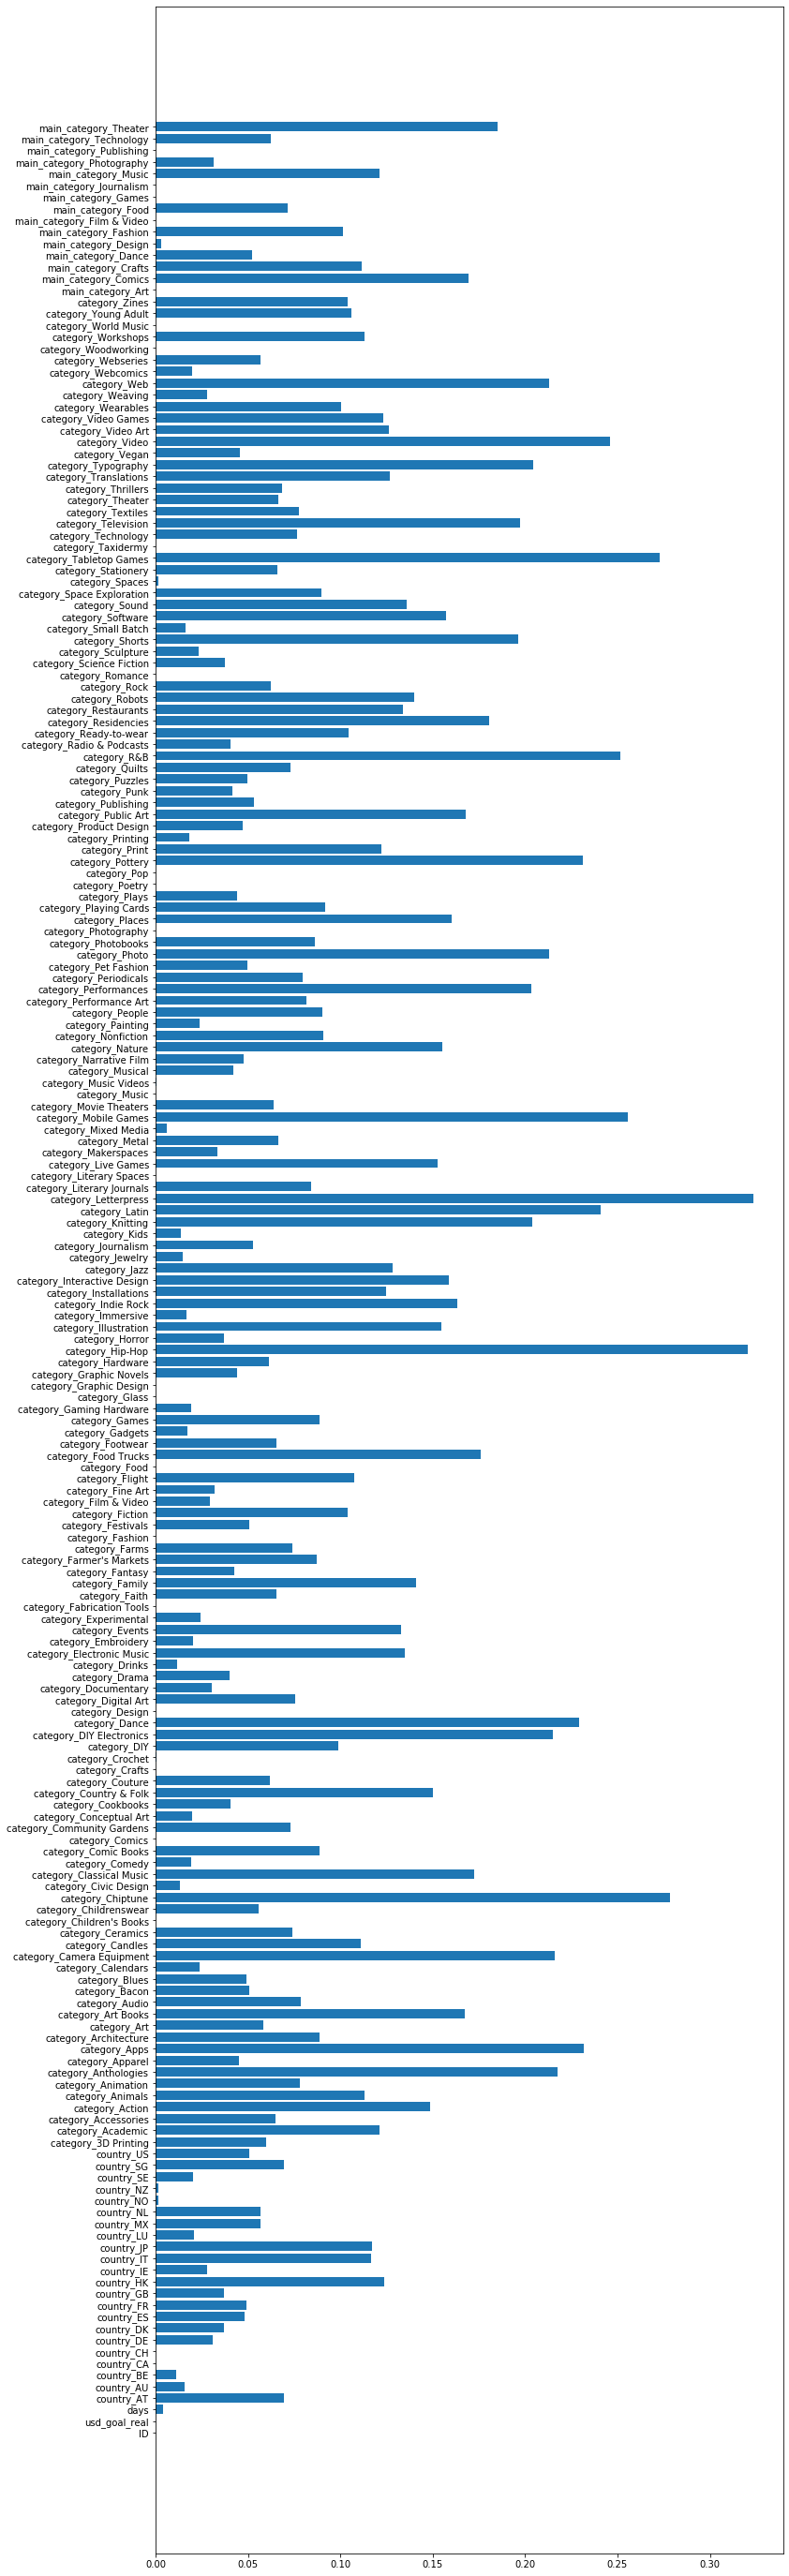

In [11]:
# 係数を棒グラフで表示
fig = plt.figure(figsize=(12, 50)) 
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix

### 削除すべき特徴量を削除して、改めて３割をテストデータ、７割を訓練データに分割する。

In [13]:
#　ラベルデータとして’state’を作成
train_label = df_train['state']

#　Leakageになりそうなカラム、相関が強いカラムをドロップする
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)
#　Lassoで削除するべき特徴量に選ばれたカラムをドロップする
train_data = train_data.drop(train_data.columns[removed_idx], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#カラムをドロップした説明変数を、Xに格納
X = train_data.values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144879, 172) (62091, 172) (144879,) (62091,)


### １層目RELU、２層目Sigmoid の２値分類　NN
### 最適化手法にはAdamを採用し学習率を変化させて、テストデータAccuracyが最大になる値を探す。
### 探すにあたっては、交差検証法を利用する。  
パラメータチューニングには３分割で交差検証を行う。

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(256, activation='tanh', input_dim=172))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#学習率毎のAccuracy格納用データフレームを初期化
df_lr_Acc = pd.DataFrame(index=[], columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])
for lr in np.arange(0.001,0.02,0.001):
    #クロスバリデーションの検証毎のAccuracy格納用データフレームを初期化
    df_val_Acc = pd.DataFrame(index=[], columns=['step','loss', 'val_loss','acc', 'val_acc'])
    #クロスバリデーションでの検証ステップを初期化
    step = 1
    #クロスバリデーションで検証
    for train_index, test_index in KFold(n_splits=3,shuffle=True, random_state=1234).split(X_train, y_train):
        X_val_train, X_val_test = X[train_index], X[test_index]
        y_val_train, y_val_test = y[train_index], y[test_index]
        print(X_val_train.shape, X_val_test.shape,y_val_train.shape, y_val_test.shape)
        
        # ------ 最適化手法 ------
        #sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
        #rms = RMSprop(lr=0.01)
        # adag = Adagrad(lr=0.01)
        # adad = Adadelta(lr=0.01)
        adam = Adam(lr=lr)
        # -----------------------------

        model.compile(loss='binary_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
    
        # 計算の実行
        fit = model.fit(X_val_train, y_val_train,epochs=10,batch_size=256,validation_data=(X_val_test, y_val_test))

        # 各epochにおける損失と精度をdfに入れる
        df = pd.DataFrame(fit.history)
    
        # グラフ化
        #df[['loss', 'val_loss']].plot()
        #plt.ylabel('loss')
        #plt.xlabel('epoch')
        #plt.show()

        #df[['acc', 'val_acc']].plot()
        #plt.ylabel('acc')
        #plt.xlabel('epoch')
        #plt.ylim([0,1.0])
        #plt.show()
        
        
        
        val_df = pd.DataFrame(index=[],columns=['step','loss', 'val_loss','acc', 'val_acc'])
        val_df = val_df.append(df,ignore_index = True,sort=False)
        val_df[['step']] = step
        
        df_val_Acc = df_val_Acc.append(val_df, ignore_index = True,sort=False) 
        step = step + 1

    lr_df = pd.DataFrame(index=[],columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])
    lr_df = lr_df.append(df_val_Acc,ignore_index = True,sort=False)
    lr_df['lr'] = lr
    
    df_lr_Acc = df_lr_Acc.append(lr_df, ignore_index = True,sort=False)


/Users/jitaku_imac/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: name 'pd' is not defined

In [39]:

display(df_lr_Acc)
display(df_val_Acc)

,lr,step,loss,val_loss,acc,val_acc
0,0.001,1,0.727639,0.682638,0.560140,0.578548
1,0.001,1,0.681440,0.673990,0.577838,0.578548
2,0.001,1,0.659855,0.638072,0.600202,0.629694
3,0.001,2,0.642050,0.626070,0.628230,0.647000
4,0.001,2,0.635500,0.624772,0.637990,0.648477
5,0.001,2,0.631958,0.625574,0.642684,0.641906


,step,loss,val_loss,acc,val_acc
0,1,0.727639,0.682638,0.560140,0.578548
1,1,0.681440,0.673990,0.577838,0.578548
2,1,0.659855,0.638072,0.600202,0.629694
3,2,0.642050,0.626070,0.628230,0.647000
4,2,0.635500,0.624772,0.637990,0.648477
5,2,0.631958,0.625574,0.642684,0.641906


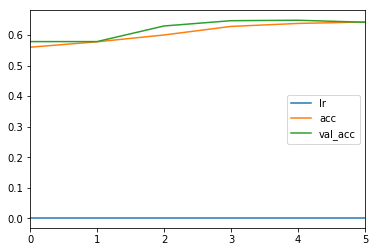

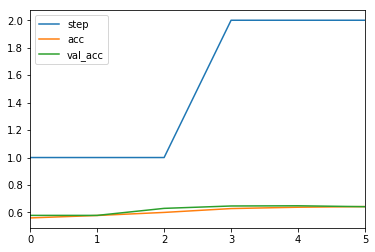

In [40]:
df_lr_Acc[['lr','acc', 'val_acc']].plot()
plt.show()
df_val_Acc[['step','acc', 'val_acc']].plot()
plt.show()

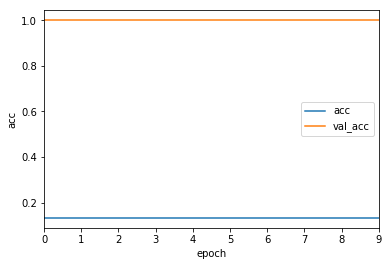

In [53]:
df[['acc', 'val_acc']].plot()
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

### 1.4. パラメータチューニング後のモデルによって、精度および結果の評価を行う

#### 学習率が0.008のときにテストデータでのAccuracyが66%で最大近いので、採用
#### epoch数を増やしてみる

Train on 144879 samples, validate on 62091 samples
Epoch 1/100
144879/144879 [==============================] - 12s 80us/step - loss: 0.6034 - acc: 0.6696 - val_loss: 0.6341 - val_acc: 0.6585
Epoch 2/100
144879/144879 [==============================] - 8s 57us/step - loss: 0.6027 - acc: 0.6697 - val_loss: 0.6352 - val_acc: 0.6590
Epoch 3/100
144879/144879 [==============================] - 8s 58us/step - loss: 0.6026 - acc: 0.6702 - val_loss: 0.6347 - val_acc: 0.6598
Epoch 4/100
144879/144879 [==============================] - 9s 63us/step - loss: 0.6027 - acc: 0.6703 - val_loss: 0.6360 - val_acc: 0.6591
Epoch 5/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6024 - acc: 0.6704 - val_loss: 0.6355 - val_acc: 0.6593
Epoch 6/100
144879/144879 [==============================] - 9s 61us/step - loss: 0.6023 - acc: 0.6703 - val_loss: 0.6371 - val_acc: 0.6582
Epoch 7/100
144879/144879 [==============================] - 9s 59us/step - loss: 0.6029 - acc: 0.6701 - va

Epoch 59/100
144879/144879 [==============================] - 8s 59us/step - loss: 0.6013 - acc: 0.6709 - val_loss: 0.6425 - val_acc: 0.6586
Epoch 60/100
144879/144879 [==============================] - 9s 59us/step - loss: 0.6014 - acc: 0.6709 - val_loss: 0.6415 - val_acc: 0.6590
Epoch 61/100
144879/144879 [==============================] - 8s 58us/step - loss: 0.6012 - acc: 0.6706 - val_loss: 0.6434 - val_acc: 0.6592
Epoch 62/100
144879/144879 [==============================] - 8s 58us/step - loss: 0.6011 - acc: 0.6709 - val_loss: 0.6437 - val_acc: 0.6590
Epoch 63/100
144879/144879 [==============================] - 8s 57us/step - loss: 0.6014 - acc: 0.6701 - val_loss: 0.6434 - val_acc: 0.6596
Epoch 64/100
144879/144879 [==============================] - 8s 58us/step - loss: 0.6017 - acc: 0.6699 - val_loss: 0.6448 - val_acc: 0.6562
Epoch 65/100
144879/144879 [==============================] - 8s 58us/step - loss: 0.6012 - acc: 0.6711 - val_loss: 0.6448 - val_acc: 0.6576
Epoch 66/100


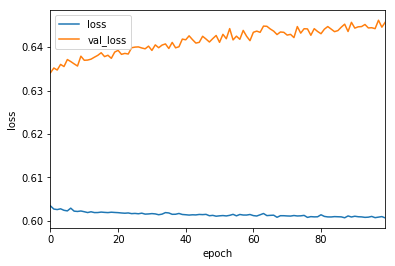

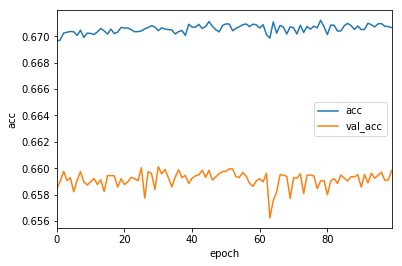

In [43]:
# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
#rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
#学習率は0.008を採用
adam = Adam(lr=0.008)
# -----------------------------

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 計算の実行
fit = model.fit(X_train, y_train,epochs=100,batch_size=2048,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
    
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
#plt.ylim([0,1.0])
plt.show()    

### エポック数を増やしても、６６％以上、精度が上がらない。
### さらなる工夫が必要。

### 1.5. その他、精度の向上ができるような処理に取り組み、精度を上げる

### 1.6. できたところまでをNotebookでまとめ、宿題として提出する  

### 1.7. 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること 

### 1.8. 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます